# Analysis on stationarity

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
import scipy.stats as stats
import time
import stationarity as st

import sys
sys.path.insert(0, '..')
from multiprocess import mp_pandas_obj

In [5]:
df = pd.read_csv("../data/BTCUSDT-volume-bars.csv", index_col=0, parse_dates=True)

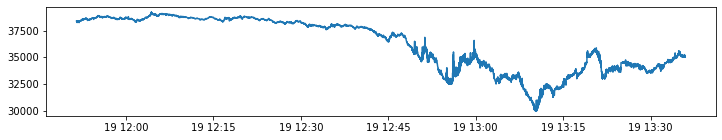

In [6]:
a = -605_000
b = -595_000

fig, ax = plt.subplots(figsize=(12, 2))

ax.plot(df.close[a:b])

In [7]:
df = df[a:b] #Manually select segment (100_000 --> ~ 10 minutes to compute)

In [8]:
# Set indicator to be pandas series (ie df.close)
ind = df.close

## Form a new series as a cumulative sum of log-amounts

In [100]:
x = np.log(ind).cumsum()
x

time
2021-05-19 11:51:31.177        10.555245
2021-05-19 11:51:32.412        21.109755
2021-05-19 11:51:33.863        31.664740
2021-05-19 11:51:35.379        42.220032
2021-05-19 11:51:36.064        52.774340
                               ...      
2021-05-19 13:35:54.101    104595.033783
2021-05-19 13:35:54.974    104605.498885
2021-05-19 13:35:55.797    104615.964456
2021-05-19 13:35:56.153    104626.429557
2021-05-19 13:35:56.493    104636.893223
Name: close, Length: 10000, dtype: float64

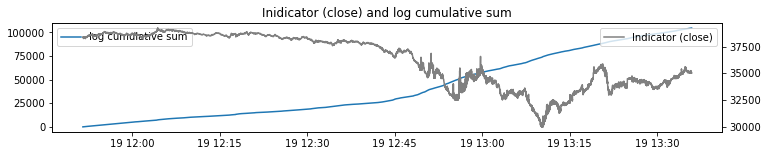

In [10]:
fig, ax = plt.subplots(figsize=(12, 2))

ax.plot(x, label="log cumulative sum")
ax1 = ax.twinx()
ax1.plot(ind, label="Indicator (close)", color="gray")
ax.set_title("Inidicator (close) and log cumulative sum")
ax.legend()
ax1.legend();

## Apply FFD, with `𝜏 = 1E − 5`
Purpose:  Determine for what minimum `d ∈ [0, 2]` the new series is stationary.

In [68]:
def get_optimal_ffd(ds, x, t=1e-5):
    
    cols = ['adfStat','pVal','lags','nObs','95% conf']#,'corr']
    out = pd.DataFrame(columns=cols)
    
    for d in ds:
        print(f"doing {d} in {ds}")
        try:
            #dfx = fracDiff(x.to_frame(),d,thres=1e-5)
            dfx = st.frac_diff_ffd(x.to_frame(),d,thres=t)
            dfx = adfuller(dfx['close'], maxlag=1,regression='c',autolag=None)
            out.loc[d]=list(dfx[:4])+[dfx[4]['5%']]
        except Exception as e:
            print(f'{d} error: {e}')
            break
    return out

In [69]:
ds = [0.1, 0.2, 0.5, 0.8, 0.9, 1., 1.2, 1.5, 1.8, 1.9, 2]
thres = 1e-5
start = time.time()
out = get_optimal_ffd(ds, x, thres) 
print(f"{'-'*15} Operation took {round((time.time()-start)/60, 2)} minutes {'-'*15}")

doing 0.1 in [0.1, 0.2, 0.5, 0.8, 0.9, 1.0, 1.2, 1.5, 1.8, 1.9, 2]
doing 0.2 in [0.1, 0.2, 0.5, 0.8, 0.9, 1.0, 1.2, 1.5, 1.8, 1.9, 2]
doing 0.5 in [0.1, 0.2, 0.5, 0.8, 0.9, 1.0, 1.2, 1.5, 1.8, 1.9, 2]
doing 0.8 in [0.1, 0.2, 0.5, 0.8, 0.9, 1.0, 1.2, 1.5, 1.8, 1.9, 2]
doing 0.9 in [0.1, 0.2, 0.5, 0.8, 0.9, 1.0, 1.2, 1.5, 1.8, 1.9, 2]
doing 1.0 in [0.1, 0.2, 0.5, 0.8, 0.9, 1.0, 1.2, 1.5, 1.8, 1.9, 2]
doing 1.2 in [0.1, 0.2, 0.5, 0.8, 0.9, 1.0, 1.2, 1.5, 1.8, 1.9, 2]
doing 1.5 in [0.1, 0.2, 0.5, 0.8, 0.9, 1.0, 1.2, 1.5, 1.8, 1.9, 2]
doing 1.8 in [0.1, 0.2, 0.5, 0.8, 0.9, 1.0, 1.2, 1.5, 1.8, 1.9, 2]
doing 1.9 in [0.1, 0.2, 0.5, 0.8, 0.9, 1.0, 1.2, 1.5, 1.8, 1.9, 2]
doing 2 in [0.1, 0.2, 0.5, 0.8, 0.9, 1.0, 1.2, 1.5, 1.8, 1.9, 2]
--------------- Operation took 2.42 minutes ---------------


In [70]:
out

,adfStat,pVal,lags,nObs,95% conf
0.1,3.341523,1.000000e+00,1.0,5923.0,-2.862028
0.2,5.102137,1.000000e+00,1.0,6617.0,-2.861977
0.5,-8.581734,7.695751e-14,1.0,9072.0,-2.861859
0.8,-3.550527,6.780406e-03,1.0,9771.0,-2.861836
0.9,-1.737904,4.116966e-01,1.0,9874.0,-2.861833
1.0,-2.039550,2.695054e-01,1.0,9997.0,-2.861829
1.2,-1.868990,3.467867e-01,1.0,9906.0,-2.861832
1.5,-1.005338,7.513123e-01,1.0,9927.0,-2.861831
1.8,-0.435544,9.039930e-01,1.0,9957.0,-2.861830
1.9,-0.300357,9.254537e-01,1.0,9968.0,-2.861830


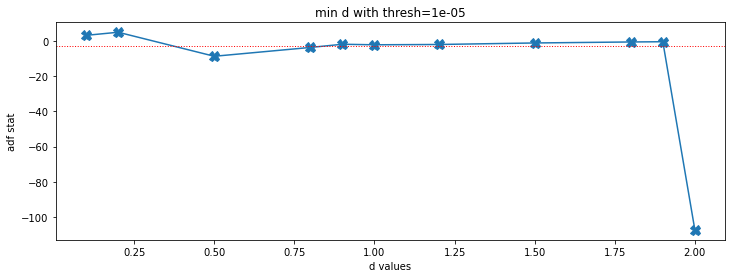

In [71]:
fig,ax=plt.subplots(figsize=(12, 4))
out['adfStat'].plot(ax=ax, marker="X", markersize=10)
ax.axhline(out['95% conf'].mean(),lw=1,color='r',ls='dotted')
ax.set_title(f'min d with thresh={thres}')
ax.set_xlabel('d values')
ax.set_ylabel('adf stat');

In [72]:
min_ffd = out[out.pVal < 0.05].iloc[0].name
min_ffd

0.5

**Augmented Dickey–Fuller test (ADF stat)**
- Null hypothesis: Time series (non-stationary)
- Alternate hypothesis: Stationary

The ADF statistic: The more negative it is, the stronger the rejection of null the hypothesis.

If p-val < 0.05, then reject null hypothesis

## Correlation of the fracdiff series to the original (untransformed) series

In [144]:
dfx2 = st.frac_diff_ffd(df.close.to_frame(),0.3,thres=1e-5) #x.to_frame() or df.close.to_frame()

In [145]:
joined = dfx2.join(ind.rename('original'), how='left') 
joined.corr()

,close,original
close,1.000000,0.665014
original,0.665014,1.000000


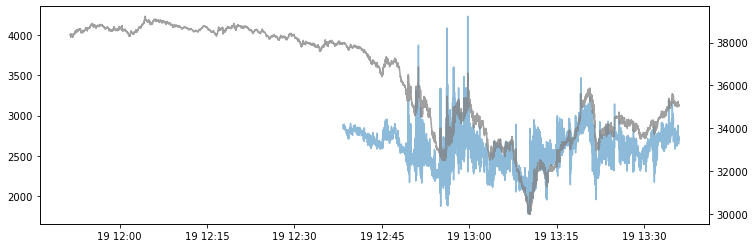

In [146]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(dfx2, alpha=.5)
ax1 = ax.twinx()
ax1.plot(ind, color="gray", alpha=.75)

In [147]:
adfuller(dfx2)

(-3.265931347271811,
 0.016471744467564393,
 28,
 7697,
 {'1%': -3.4311998742614604,
  '5%': -2.8619155814941277,
  '10%': -2.5669699174934886},
 95724.56505444404)

## Engel-Granger cointegration test on the original and fracdiff series
- Null hypothesis: No cointegration exists (non-stationary)
- Alternate hypothesis: Cointegrated (stationary)

Results:
- coint_t : The t-statistic of unit-root test on residuals.
- pvalue : MacKinnon"s approximate, asymptotic p-value based on MacKinnon (1994).
- crit_value : Critical values for the test statistic at the 1 %, 5 %, and 10 %
    levels based on regression curve. This depends on the number of
    observations.

In [149]:
coint(joined.close, joined.original)

(-3.684421635951252,
 0.019187597994789623,
 array([-3.89785828, -3.33692107, -3.04499907]))

## Jarque-Bera normality test
The Jarque-Bera test tests whether the sample data has the skewness and
kurtosis matching a normal distribution.

The test statistic is always nonnegative. If it is far from zero, it signals the data do not have a normal distribution.


In [150]:
stats.jarque_bera(dfx2)

Jarque_beraResult(statistic=834.7349735106567, pvalue=0.0)

## Result

In [151]:
print(f"d = {min_ffd}, threshold = {thres}")

d = 0.5, threshold = 1e-05
